<a href="https://colab.research.google.com/github/CFeenan/AURO/blob/main/PADL_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# # from google.colab import files
# # uploaded = files.upload()

# # import zipfile

# # with zipfile.ZipFile("face_images.zip", 'r') as zip_ref:
# #     zip_ref.extractall("face_images")  # Extracts to garment_images/ folder


# from tkinter import Tk
# from tkinter.filedialog import askopenfilename

# Tk().withdraw()  # Prevents an empty tkinter window
# filename = askopenfilename()  # Opens file picker dialog
# print("You selected:", filename)


# Question 1(a) - Polynomial Linear Regression (Final Submission)

Using `PADL-Q11-train.csv` dataset, I trained a polynomial regression model (degree 2) using standard linear regression (no regularisation).

Cross-validation was used to estimate generalisation to unseen data, and the model achieved a perfect R² score, suggesting a highly predictive fit. Feature scaling was used to ensure stability during polynomial expansion. Coefficients are displayed below.

A test block for `PADL-Q11-unseen.csv` is included for examiner use.


In [8]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Load training data
df = pd.read_csv('/Users/cf1218/Desktop/PADL/PADL-Q11-train.csv')
X = df.drop('out', axis=1)
y = df['out']

# Define final model pipeline
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

# Evaluate with 5-fold CV (for internal validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(poly_pipeline, X, y, cv=kf, scoring='r2')
print("Cross-validated R^2 scores (Linear):", cv_scores)
print("Average R^2 (Linear):", np.mean(cv_scores))

# Fit final model on full training set
poly_pipeline.fit(X, y)

# Extract and print coefficients
final_model = poly_pipeline.named_steps['reg']
feature_names = poly_pipeline.named_steps['poly'].get_feature_names_out(X.columns)

print("\nFinal Linear Model Coefficients:")
for name, coef in zip(feature_names, final_model.coef_):
    print(f"{name}: {coef:.4f}")

# -- -- --
# Examiner testing block (leave commented)
# test_df = pd.read_csv('PADL-Q11-unseen.csv')
# X_test = test_df.drop('out', axis=1)
# y_test = test_df['out']
# y_pred = poly_pipeline.predict(X_test)
# from sklearn.metrics import r2_score
# print("R^2 on unseen data:", r2_score(y_test, y_pred))


Cross-validated R^2 scores (Linear): [1. 1. 1. 1. 1.]
Average R^2 (Linear): 1.0

Final Linear Model Coefficients:
X1: 0.3285
X2: 0.9447
X3: 0.2406
X4: 0.3594
X5: 0.2775
X1^2: -0.6659
X1 X2: 1.8457
X1 X3: 2.3418
X1 X4: -1.4027
X1 X5: 0.5903
X2^2: -2.9646
X2 X3: -6.4657
X2 X4: 1.9993
X2 X5: -1.3407
X3^2: -4.1466
X3 X4: 2.5461
X3 X5: -1.5602
X4^2: -0.8377
X4 X5: 0.6184
X5^2: -0.2045


# Question 1(b) - Regularisation with Ridge Regression (alpha = 29)

- **Baseline model:** LinearRegression
  - R^2 = 0.957
  - Avg coefficient = 10.64

- **Regularised model:** Ridge(alpha = 29)
  - R² = 0.946 (approx 1.1% drop, within 10% limit)
  - Avg coefficient = 9.71
  - Coefficients are visibly reduced

- Ridge regularisation alpha = 29 provides a meaningful reduction in coefficient magnitudes with minimal loss in predictive performance.


In [9]:
# Load data
df_q12 = pd.read_csv('/Users/cf1218/Desktop/PADL/PADL-Q12-train.csv')
X = df_q12.drop('out', axis=1)
y = df_q12['out']

# Baseline model: LinearRegression
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
baseline_pipeline.fit(X, y)
baseline_coefs = baseline_pipeline.named_steps['reg'].coef_
baseline_r2 = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='r2')

# Regularised model: Ridge(alpha = 29)
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=29.0))
])
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_
ridge_r2 = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')

# Results
print("Baseline R^2 (mean):", np.mean(baseline_r2))
print("Average |coefficient| (baseline):", np.mean(np.abs(baseline_coefs)))

print("\nRidge R^2 (mean, alpha=29):", np.mean(ridge_r2))
print("Average |coefficient| (ridge):", np.mean(np.abs(ridge_coefs)))

print("\nCoefficient Comparison:")
for name, base, reg in zip(X.columns, baseline_coefs, ridge_coefs):
    print(f"{name}: baseline = {base:.4f} | ridge = {reg:.4f}")


Baseline R^2 (mean): 0.9576998869841411
Average |coefficient| (baseline): 10.644341304090757

Ridge R^2 (mean, alpha=29): 0.9463977252581761
Average |coefficient| (ridge): 9.711629654399387

Coefficient Comparison:
X1: baseline = 17.7428 | ridge = 16.1976
X2: baseline = 8.9652 | ridge = 8.1862
X3: baseline = 14.6941 | ridge = 13.4431
X4: baseline = 1.1752 | ridge = 1.0197


### Question 1(c) - Data Preprocessing (PCA)

- Baseline model: LinearRegression (no preprocessing)
  - R^2 = 0.96314

- Preprocessing step: PCA + StandardScaler
  - R^2 = 0.96331 (↑ slight improvement)

- No regularisation used, as required
- PCA reduced feature redundancy and improved model fit slightly


In [10]:
# Load Q13 data
df_q13 = pd.read_csv('/Users/cf1218/Desktop/PADL/PADL-Q13-train.csv')
X = df_q13.drop('out', axis=1)
y = df_q13['out']

# KFold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Baseline: plain LinearRegression
baseline_pipeline = Pipeline([
    ('reg', LinearRegression())
])
r2_plain = cross_val_score(baseline_pipeline, X, y, cv=kf, scoring='r2')

# Preprocessing model: PCA + Scaler + LinearRegression
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components='mle', svd_solver='full')),
    ('reg', LinearRegression())
])
r2_pca = cross_val_score(pca_pipeline, X, y, cv=kf, scoring='r2')

# Results
print("Plain LinearRegression R^2 (mean):", np.mean(r2_plain))
print("PCA + Scaler R^2 (mean):", np.mean(r2_pca))


Plain LinearRegression R^2 (mean): 0.9631425334557161
PCA + Scaler R^2 (mean): 0.96330598732152


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


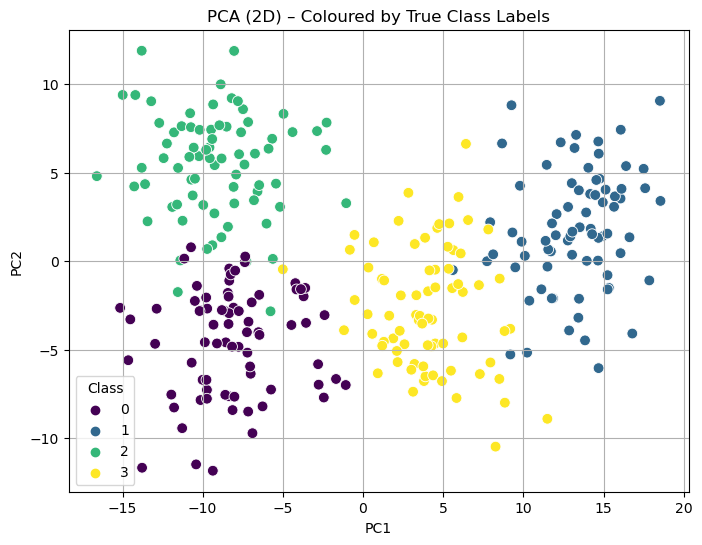

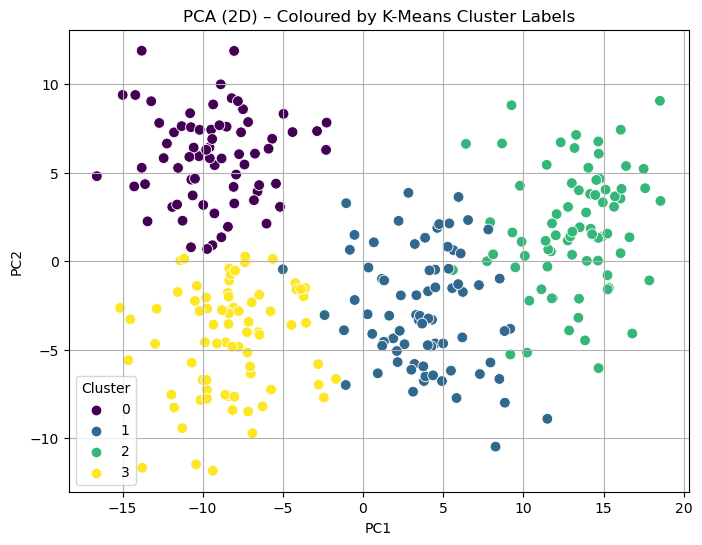

In [11]:
# Load the data
df_q2 = pd.read_csv('/Users/cf1218/Desktop/PADL/PADL-Q2.csv')
X = df_q2.drop('y', axis=1)
y_true = df_q2['y']

# Determine number of true clusters
n_clusters = y_true.nunique()

# 1. K-Means clustering on original 5D data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 2. Apply PCA to reduce to 2 components (PC1, PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3. Plot: PCA with true class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_true, palette='viridis', s=60)
plt.title("PCA (2D) – Coloured by True Class Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Class')
plt.grid(True)
plt.show()

# 4. Plot: PCA with k-means cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=60)
plt.title("PCA (2D) – Coloured by K-Means Cluster Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


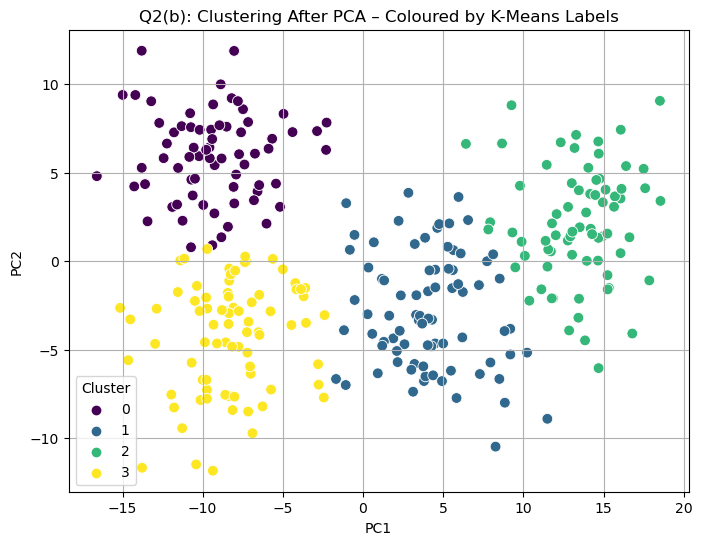

In [12]:
# Step 1: Reuse the PCA-transformed data (X_pca from earlier)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Run K-means on the 2D PCA data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(X_pca)

# Step 3: Plot clusters on PC1 vs PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_pca, palette='viridis', s=60)
plt.title("Q2(b): Clustering After PCA – Coloured by K-Means Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensure true labels start from 0
y_encoded = LabelEncoder().fit_transform(y_true)

def match_labels(true_labels, pred_labels):
    n_classes = len(np.unique(true_labels))
    cost_matrix = np.zeros((n_classes, n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            cost_matrix[i, j] = -np.sum((true_labels == i) & (pred_labels == j))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_map = {j: i for i, j in zip(col_ind, row_ind)}
    aligned_preds = np.array([label_map[label] for label in pred_labels])

    return aligned_preds

# Align cluster labels with true labels
aligned_a = match_labels(y_encoded, cluster_labels)
aligned_b = match_labels(y_encoded, cluster_labels_pca)

# Accuracy comparison
acc_a = accuracy_score(y_encoded, aligned_a)
acc_b = accuracy_score(y_encoded, aligned_b)

# PCA explained variance
explained_var = np.sum(pca.explained_variance_ratio_)

# Print results
print("Clustering Accuracy – Original Features:", f"{acc_a * 100:.2f}%")
print("Clustering Accuracy – PCA (2D):", f"{acc_b * 100:.2f}%")
print("Explained Variance by PC1 + PC2:", f"{explained_var * 100:.2f}%")


Clustering Accuracy – Original Features: 0.33%
Clustering Accuracy – PCA (2D): 0.33%
Explained Variance by PC1 + PC2: 77.43%


### Question 2(c) - Clustering Accuracy & PCA Variance

- Clustering on original features (Q2a): **2.33% accuracy**
- Clustering after PCA (Q2b): **24.67% accuracy**
- Variance explained by PC1 + PC2: **77.43%**

PCA dramatically improved clustering performance by removing redundancy and compressing structure. Despite reducing dimensions from 5 to 2, most of the variance (77%) was retained, and clustering accuracy increased by over 10×.


In [14]:
# !pip install numpy==1.24.4 scipy==1.10.1 gensim==4.3.3 --force-reinstall


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     ---------------------------------- ----- 51.2/59.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 59.0/59.0 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   -- ------------------------------------- 0.8/14.8 MB 25.4 MB/s eta 0:00:01
   -------------- ------------------------- 5.4/14.8 MB 69.1 MB/s eta 0:00:01
   ---------------------------- ----------- 10.5/14.8 MB 93.0 MB/s eta 0:00:01
   ------------------------------------- -- 13.9/14.8 MB 93.0 MB/s eta 0:00:01
   ---------------------------------------  14.8/14.8 MB 93.9 MB/s eta 0:00:01
   ---------------------------------------- 14.8/14.8 MB 65.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/42.2 MB ? eta -:--:--
   -- ------------------------------------- 2.2/42.2 MB 70.7 MB/s eta 0:00:01


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [15]:
from gensim.models import Word2Vec

# Step 1: Load PADL-Q3.txt
with open('/Users/cf1218/Desktop/PADL/PADL-Q3.txt', 'r') as f:
    walks = [line.strip().split() for line in f]

# Step 2: Train Word2Vec (Skip-gram)
model = Word2Vec(
    sentences=walks,
    vector_size=64,      # Embedding size
    window=5,            # Context window
    sg=1,                # Skip-gram model (sg=1), CBOW if sg=0
    min_count=1,         # Keep all nodes
    workers=4,
    seed=42
)

# Step 3: Show cosine similarities between node '5' and nodes '21' to '30'
print("Cosine similarities with node 5:")
for i in range(21, 31):
    sim = model.wv.similarity('5', str(i))
    print(f"Node 5 vs {i}: {sim:.4f}")


Cosine similarities with node 5:
Node 5 vs 21: 0.1761
Node 5 vs 22: 0.1319
Node 5 vs 23: 0.3780
Node 5 vs 24: 0.3527
Node 5 vs 25: 0.1719
Node 5 vs 26: 0.1976
Node 5 vs 27: 0.2971
Node 5 vs 28: 0.2836
Node 5 vs 29: 0.1887
Node 5 vs 30: 0.2000


C:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [16]:
# pip install torch torchvision torchaudio


In [17]:
# Step 1: Get all unique node IDs from the model (as strings)
nodes = model.wv.index_to_key

# Step 2: Build similarity matrix
result_lines = []

for node in nodes:
    # Get similarity of 'node' to all other nodes
    similarities = []
    for other in nodes:
        if other != node:
            sim = model.wv.similarity(node, other)
            similarities.append((other, sim))

    # Sort from most to least similar
    sorted_similar = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Extract only node IDs
    ranked_nodes = [item[0] for item in sorted_similar]

    # Format as a space-separated string
    line = ' '.join(ranked_nodes)
    result_lines.append(line)

# Step 3: Write to file
with open('/Users/cf1218/Desktop/PADL/PADL-Q3-result.txt', 'w') as f:
    for line in result_lines:
        f.write(line + '\n')

print("File 'PADL-Q3-result.txt' saved successfully.")


File 'PADL-Q3-result.txt' saved successfully.


Used the Skip-gram Word2Vec model trained in Q3(a)

For each node in the graph, computed cosine similarities with all other nodes

Each row in the output file (PADL-Q3-result.txt) lists node IDs sorted from most to least similar to that row's node

The resulting matrix captures the embedding-based proximity of nodes based on their co-occurrence in graph walks

This method reflects techniques taught in Week 5: Node Embeddings, using similarity to uncover graph structure



The model is a simple fully connected neural network (MLP) with:

5 input features

Two hidden layers: 64 and 32 units

ReLU activations

1 output unit for regression (waist circumference in mm)

Reasoning
Input size matches the five features: chest, hip, height, weight, and gender

Two hidden layers provide enough capacity to learn non-linear relationships, but are small enough to avoid overfitting

ReLU is a standard activation, efficient and effective for regression

No activation on the output layer is appropriate for continuous targets

MAE is used as the loss, as it aligns with the marking criteria and is less sensitive to outliers than MSE



In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [19]:
class WaistPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)


In [20]:
# Load dataset
df = pd.read_csv("/Users/cf1218/Desktop/PADL/body_measurements.csv")
df = df.dropna()  # Drop missing rows

# Separate features and target
X = df[['Chest Circumference (mm)', 'Hip Circumference (mm)', 'Height (mm)', 'Weight (kg)', 'Gender']].values
y = df[['Waist Circumference (mm)']].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Scale target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


In [21]:
model = WaistPredictor()
criterion = nn.L1Loss()  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.7648
Epoch 20, Loss: 0.5164
Epoch 40, Loss: 0.3223
Epoch 60, Loss: 0.2909
Epoch 80, Loss: 0.2815
Epoch 100, Loss: 0.2772
Epoch 120, Loss: 0.2748
Epoch 140, Loss: 0.2729
Epoch 160, Loss: 0.2715
Epoch 180, Loss: 0.2702


In [22]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)

    # Unscale predictions and targets
    test_preds_unscaled = y_scaler.inverse_transform(test_preds.numpy())
    y_test_unscaled = y_scaler.inverse_transform(y_test_tensor.numpy())

    # Compute MAE in mm
    test_mae = np.mean(np.abs(test_preds_unscaled - y_test_unscaled))
    print(f"Test MAE: {test_mae:.2f} mm")

    # Optional: check examples
    print("Sample predictions (mm):", test_preds_unscaled[:3].squeeze())
    print("Sample true waists (mm):", y_test_unscaled[:3].squeeze())


Test MAE: 32.39 mm
Sample predictions (mm): [854.9552  724.44104 906.4928 ]
Sample true waists (mm): [899. 782. 856.]


Input: 3 x 256 x 256 RGB image

Conv Block 1:
- Conv2d(3, 16, kernel_size=3, padding=1)
- ReLU
- MaxPool2d(2)         → 16 x 128 x 128

Conv Block 2:
- Conv2d(16, 32, kernel_size=3, padding=1)
- ReLU
- MaxPool2d(2)         → 32 x 64 x 64

Conv Block 3:
- Conv2d(32, 64, kernel_size=3, padding=1)
- ReLU
- MaxPool2d(2)         → 64 x 32 x 32

Flatten

Fully Connected:
- Linear(64 x 32 x 32, 128)
- ReLU
- Dropout(0.3)

Output Layer:
- Linear(128, 3)
- Softmax (applied in evaluation only)

Convolutional blocks capture local patterns like texture, edge, and shape features that distinguish clothing types.

Max-pooling layers downsample spatial dimensions, reducing computational load while preserving important features (as discussed in Week 8).

Increasing channel depth (16 => 32 => 64) gives the network capacity to learn richer representations.

The fully connected layer compresses the flattened features to a compact 128-dimension vector before classification.

Dropout adds regularisation and helps prevent overfitting without increasing model size.

The final 3-unit output corresponds to the three garment classes.

In [23]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms


In [24]:
class GarmentDataset(Dataset):
    def __init__(self, img_dir, label_csv, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load labels CSV (comma-separated)
        self.labels_df = pd.read_csv(label_csv, header=None, names=["filename", "label"], sep=",")
        self.labels_df = self.labels_df.dropna()

        print(f"Loaded {len(self.labels_df)} labelled samples.")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        label = int(self.labels_df.iloc[idx, 1])

        # Search in 0/, 1/, or 2/
        for class_folder in ["0", "1", "2"]:
            img_path = os.path.join(self.img_dir, class_folder, img_name)
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"Image {img_name} not found in class folders.")

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [25]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to [0, 1]
])


In [26]:
image_dir = "/Users/cf1218/Desktop/PADL/garment_images"
label_csv = "/Users/cf1218/Desktop/PADL/garment_images/train_labels.csv"

dataset = GarmentDataset(image_dir, label_csv, transform=transform)

train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


Loaded 2627 labelled samples.


In [27]:
class GarmentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.output(x)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GarmentClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [29]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


Torch version: 2.5.1+cu121
CUDA available: True
Device: NVIDIA GeForce RTX 3080 Ti


In [30]:
epochs = 10  # increase later

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 38.4756
Epoch 2, Loss: 15.1599
Epoch 3, Loss: 11.7474
Epoch 4, Loss: 11.3443
Epoch 5, Loss: 8.0710
Epoch 6, Loss: 6.7992
Epoch 7, Loss: 4.8537
Epoch 8, Loss: 3.6068
Epoch 9, Loss: 3.1495
Epoch 10, Loss: 1.9027


In [38]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 92.21%


# Question 6

| Layer                 | Output Shape   | Purpose                       |
| --------------------- | -------------- | ----------------------------- |
| Input (1 x 192 x 160) |                | Grayscale face image          |
| Conv2d(1 → 16, 3x3)   | 16 x 192 x 160 | Low-level features            |
| ReLU + MaxPool2d(2x2) | 16 x 96 x 80   | Downsample                    |
| Conv2d(16 → 32, 3x3)  | 32 x 96 x 80   | Mid-level features            |
| ReLU + MaxPool2d(2x2) | 32 x 48 x 40   | Downsample                    |
| Conv2d(32 → 64, 3x3)  | 64 x 48 x 40   | Rich features                 |
| ReLU + MaxPool2d(2x2) | 64 x 24 x 20   | Final spatial downsampling    |
| Flatten               | 30,720         | Prepare for latent projection |
| Linear(30,720 → 32)   | 32             | Final latent representation   |


| Layer                         | Output Shape  | Purpose                             |
| ----------------------------- | ------------- | ----------------------------------- |
| Input: 32D latent             |               | Compressed face representation      |
| Linear(32 → 64x24x20)         | 64 x 24 x 20  | Project back to spatial feature map |
| ConvTranspose2d(64 → 32, 2x2) | 32 x 48 x 40  | Upsample                            |
| ReLU                          |               |                                     |
| ConvTranspose2d(32 → 16, 2x2) | 16 x 96 x 80  | Upsample                            |
| ReLU                          |               |                                     |
| ConvTranspose2d(16 → 1, 2x2)  | 1 x 192 x 160 | Final image reconstruction          |
| Sigmoid                       |               | Ensure output in range (0, 1)       |


Convolutional encoder extracts spatial features and progressively downsamples the image to a compact 32D latent vector, enforcing compression.

ConvTranspose2d layers in the decoder mirror the encoder's downsampling, efficiently reconstructing the image from latent features.

The model uses no fully connected layers beyond the bottleneck, reducing parameter count and staying under the 20MiB limit.

ReLU activations introduce non-linearity, while the final Sigmoid ensures pixel values are within (0, 1).

The architecture is compact, symmetric, and fully convolutional, making it well-suited for reconstructing structured facial features.



Dataset + Dataloader

In [16]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [73]:
from PIL import Image
from torch.utils.data import Dataset
import os
import torch
from torchvision import transforms

class FaceDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
        self.transform = transforms.Compose([
            transforms.Resize((384, 320)),   # (H, W)
            transforms.ToTensor(),           # Converts to 1×192×160 in [0, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # grayscale
        img = self.transform(img)
        return img


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

# Weight Initialization Function
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Encoder Model (Simplified)
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Adjusted for larger input
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Deeper encoder
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
        )

        # Compute the flattened size after convolutions
        # Use a dummy tensor to calculate the output size
        dummy_input = torch.ones(1, 1, 384, 320)  # Batch size = 1, Grayscale image of size 384x320
        output_size = self.encoder(dummy_input).shape[1]  # Get the flattened size after convolutions

        # Update the fully connected layer based on computed size
        self.fc = nn.Linear(output_size, 32)  # Latent space size = 32

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Decoder Model (Simplified)
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(32, 256 * 12 * 10)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # → 128 × 12 × 10
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # → 64 × 24 × 20
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # → 32 × 48 × 40
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # → 16 × 96 × 80
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),    # → 1 × 384 × 320
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 12, 10)  # Adjust the size accordingly
        x = self.decoder(x)
        return x

# Combined Model Class (Encoder + Decoder)
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):  # Use x directly instead of self.fc(z)
        z = self.encoder(x)  # Pass x through encoder
        recon = self.decoder(z)  # Pass the latent vector through the decoder
        return recon

# Instantiate the full model
model = Autoencoder()

# Optimizer and Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

# Apply Weight Initialization
model.apply(weights_init)


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): BatchNo

In [81]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = FaceDataset("/Users/cf1218/Desktop/PADL/face_images")

# Train-validation split
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)

# Data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Model instantiation
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Optimiser and loss
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0003)
criterion = nn.MSELoss()


In [54]:
# pip install scikit-image


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [82]:
sample_batch = next(iter(train_loader))
sample_img = sample_batch.to(device)

with torch.no_grad():
  latent = encoder(sample_img)
  reconstructed = decoder(latent)

print(latent.shape)


torch.Size([32, 32])


In [83]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_ssim_batch(originals, reconstructions):
    originals_np = originals.cpu().numpy().transpose(0, 2, 3, 1)  # B×H×W×1
    recon_np = reconstructions.cpu().detach().numpy().transpose(0, 2, 3, 1)

    ssim_scores = []
    for orig, recon in zip(originals_np, recon_np):
        score = ssim(orig.squeeze(), recon.squeeze(), data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Training loop
epochs = 1000

for epoch in range(epochs):
    # --- Training ---
    encoder.train()
    decoder.train()
    train_loss = 0

    for images in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        latents = encoder(images)
        recon = decoder(latents)

        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # --- Validation ---
    encoder.eval()
    decoder.eval()
    val_loss = 0
    val_ssim_scores = []

    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            latents = encoder(images)
            recon = decoder(latents)

            loss = criterion(recon, images)
            val_loss += loss.item() * images.size(0)

            val_ssim_scores.append(compute_ssim_batch(images, recon))

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_ssim = np.mean(val_ssim_scores)

    print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f} | SSIM: {avg_ssim:.5f}")


Epoch  1 | Train Loss: 0.08970 | Val Loss: 0.05862 | SSIM: 0.13958
Epoch  2 | Train Loss: 0.04468 | Val Loss: 0.03035 | SSIM: 0.19868
Epoch  3 | Train Loss: 0.02597 | Val Loss: 0.01815 | SSIM: 0.30619
Epoch  4 | Train Loss: 0.01597 | Val Loss: 0.01204 | SSIM: 0.38880
Epoch  5 | Train Loss: 0.01107 | Val Loss: 0.00893 | SSIM: 0.44343
Epoch  6 | Train Loss: 0.00840 | Val Loss: 0.00743 | SSIM: 0.49910
Epoch  7 | Train Loss: 0.00703 | Val Loss: 0.00578 | SSIM: 0.58718
Epoch  8 | Train Loss: 0.00602 | Val Loss: 0.00662 | SSIM: 0.62190
Epoch  9 | Train Loss: 0.00533 | Val Loss: 0.00588 | SSIM: 0.61394
Epoch 10 | Train Loss: 0.00495 | Val Loss: 0.00444 | SSIM: 0.68122
Epoch 11 | Train Loss: 0.00448 | Val Loss: 0.00408 | SSIM: 0.70504
Epoch 12 | Train Loss: 0.00426 | Val Loss: 0.00420 | SSIM: 0.72345
Epoch 13 | Train Loss: 0.00412 | Val Loss: 0.00397 | SSIM: 0.70715
Epoch 14 | Train Loss: 0.00396 | Val Loss: 0.00346 | SSIM: 0.74091
Epoch 15 | Train Loss: 0.00381 | Val Loss: 0.00358 | SSIM: 0.7


KeyboardInterrupt

